# Guide to forecasting using autoARIMA
by Ian Sulzmann

**This notebook is designed to act as an easy template to build an ARIMA model and also as a delivable notebook for seminars following the theory from 05_time_series_models. The code will work as is as long as you set up your dataframe as expected in step 1.**

This guide focuses on practical explanations throughout, but does not cover the mathematics and manual parameter selection in enough detail to forecast to an industry expert level. However it serves as a solid introduction and template that will handle the majority of timeseries well and to a standard on par with many automated forecasting tools such as PowerBI (but with a bit of extra control).


# 0. What is ARIMA and autoARIMA

SARIMAX is a forecasting model based upon 3 techniques, autoregression "AR",  moving average "MA" and Integrating "I" (also commonly called differencing). It can also handle seasonality "S" and exogenous variables "X". (That is any other (non time) variable that can help forecast the dependant variable.) 

autoARIMA is a tool that calculates the best parameters for a SARIMAX model for you. This simplifies an otherwise very difficult process.

To simplify: SARIMAX is ARIMA with all the extra bells and whistles and autoARIMA helps you choose the best settings.

If you would like to learn to finetune every parameter of SARIMAX by hand please refer to the Time Series Step by Step Guide by Harry Gulliver, otherwise we will let autoARIMA automate this.


**Why so many components?**

AR and MA are designed to handle the fluctuations of a time series. Long-term they tend to a fixed number which will be a better forecast than using any simple or rolling average. However they do not capture long term trends.

Integrating is a technique that is added to AR and MA to allow them to capture long-term trends. In essence, the model takes out the trend by differencing the data (see 05_time_series_models) which leaves just the leftover noise of  fluctuations and any seasonality. AR and MA is then used to forecast this and handle the randomness. Finally, the differencing is then reversed, which adds the long-term trend back.

Seasonality is a technique that allows the model to adjust for seasonal variation. For example, if certain months typically have higher values than other. SARIMAX uses the same principles of MA, AR, I, but on a seasonal timescale to model seasonality.


It is only in combination of the components that SARIMAX becomes a powerful tool. In isolation they are rather limited.


**Lets see some examples of this.**

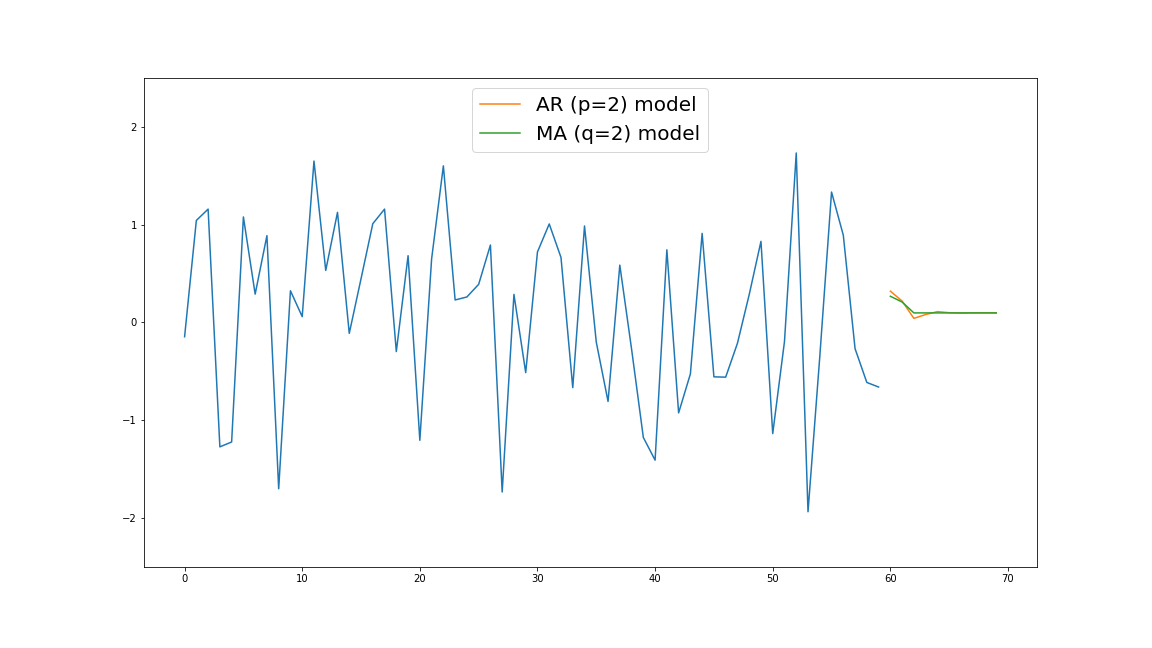

Note MA and AR worked well in the first example. But they fail on the timeseries with a long-term trend. AR models typically tend to a prediction near more recent data points and the MA model fails to converge on anything useful in this case. 

However, if we add differencing (I) as well, the forecast works nicely. Here we show a (1,1,0) and a (0,1,1) model: That is AR with I and MA with I, following the typical (AR,I,MA) convention.

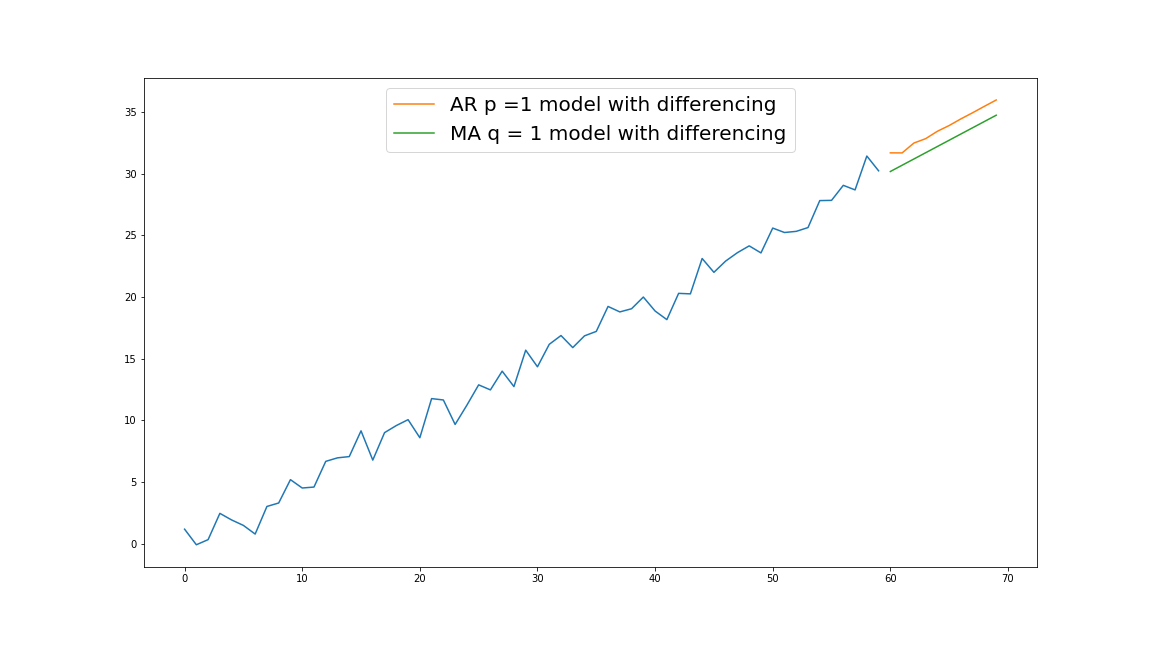

# 0. Forecasting Template

In [ ]:
!pip install pmdarima #https://pypi.org/project/pmdarima/

In [ ]:
#imports
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Data prep

In [ ]:
#Import data and cleaning. 
#This notebook uses data on UK bus usage.
df = pd.read_csv('data/bus.csv')

#rename prediciton column to output and drop any other columns which we do not need.
df.columns = ['month', 'output']
#df.drop(['col1', 'col2' etc], axis = 1, inplace = True)

#we use generic names for the dataframe and columns for automation purposes in this notebook.

#drop problematic rows and nulls (in this case there is some unstructured data in row 115)
df.drop(115, inplace = True)
df.dropna(inplace = True)

#make sure dependent variable is numeric
df.output = df.output.astype(float)

#convert date column to datetime, change format as required. '%Y represents a 4 digit year. %m the month and %d the day.
#In this case, the dates are represented like "1960-01", so we use '%Y-%m'. For dates represented as '2021/01/15', for example, we would use '%Y/%m/%d'.
df['month'] = pd.to_datetime(df.month, format='%Y-%m')

#set index to datatime column
df.set_index('month', inplace=True, drop = True)

#resample to the level of granularity needed for forecasting.
#Our data is monthly which is fine. If we wished to resample to yearly we could use the below.
#df = df.resample('Y').sum()

df.head()
#dataframe should now consist of one column named "output" with an index as the datetime. 

**Reminder: Drop any columns which aren't the time index or the timeseries value! This notebook assumes this has be done in the code later on.**

df = df[['output']].copy()


# 2. Train Test Split

We shall train test split our data and use the following process.

Train the model on the oldest 80% of the data and plot its predicted forecast overlayed onto the remaining most recent 20% test data to check if it is performing reasonably. 

Assuming the above is okay, we can then train the model on our full time period of data and let it forecast into the future.


In [ ]:
#This split % could be adjusted for contextual seasonality reasons if desired (e.g. if we want to include a full cycle of the time period in our training set).

#Also generally avoid splitting at anomalous spikes in the timeseries as this might skew our results.

#adjust the 0.8 as needed
train = df.iloc[:int(df.shape[0]*0.8)]
test = df.iloc[int(df.shape[0]*0.8):]

#check worked
print(train.shape, test.shape)


#check worked on graph
fig, ax = plt.subplots()
train.output.plot(ax=ax, label='train')
test['output'].plot(ax=ax, label='test')
ax.legend(loc='best')

# 3 Using autoARIMA for parameter selection


autoARIMA chooses the best paramaters for us except for 1, m which is the seasonality.
m is the number of rows in one seasonal period. E.g for monthly data with a yearly pattern m = 12. Or m=7 for weekly seasonality on daily data.

**Please, update m for your data in the cell below!**

If you unsure of the seasonality there is a guide at the end of this notebook. But for the time being, if you have a suspicion of a certain seasonality try that, but otherwise best to not use seasonality and change the below code to "seasonal = False".

In [ ]:
#Here we use auto_arima model to find the best SARIMAX parameters for our particular time series.
arima_model = pm.auto_arima(train, start_p=0, start_q=0, max_p=3, max_q=3,
                             start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True, m=12, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work.
                             suppress_warnings=True,  # don't want convergence warnings.
                             trend = 'c') #Includes a constant in the formula. Very important if d = 0 and mean is not 0.
                               
#Here we use m = 12. Change this as needed.

The best parameters are revealed to be ARIMA(0,1,0)(1,0,1)[12]  as this model had the lowest AIC error of all options considered.

We will use those parameters in a SARIMAX model in step 4

Note that the initial parameters in the code above are p,q,P,Q min & max values for autoARIMA to cycle through and find the best performing values.

It would be extremely rare to need p,q,P,Q > 3 so you can leave max_p = 3 as they are.

**Caveat: autoARIMAs weakness with choosing d and D**

autoARIMA will try to choose the best d value via the Augmented Dickey-Fuller test (see here: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html).
If we wish to specify d or D manually, you can add "d= " and "D= " parameters above. Note that autoARIMA will not check d = 1 if d = 0 seems feasible and likewise for D so it can sometimes fail to find the best fit. In fact, this example did not investigate d=1, D=1 which produces a better model for this data! Try setting d=1, D=1 above and compare the scores.


Note: changing p,q,P,Q has a relatively smaller effect on the model forecast compared to changing d and D, which can have a huge impact. Therefore, we will discuss further setting d and D manually later in this template as an optional extension.

For a quick solution, use autoARIMA for d & D and check if the model is reasonable. Do not set d,D above 1 unless you have good reason as this increases model variability significantly which can cause severe overfitting. I.e a forecast may perform very well on the seen train data but drifts off significantly in the test time period and perform very badly.


# 4 Building the SARIMAX model

In [ ]:
model = SARIMAX(train, order=(0,1,0), seasonal_order=(1,0,1,12)).fit()

#the order is (p,d,q) and the seasonal order is (P,D,Q,m)
#note they appear in the same order as the above output ARIMA(0,1,0)(0,1,1)[12]

In [ ]:
forecast = model.get_forecast(test.shape[0]).summary_frame()
#test.shape[0] tells the model how many data points there are in the test set and therefore how far to forecast.
forecast.head()

The mean is the estimated forecast.
Mean_se is the estimated error.
CI_lower and CI_upper are the confidence intervals. The lower and upper bound of what the model thinks the real values could fall between.

In [ ]:
#lets plot its performance.
fig, ax = plt.subplots(figsize=(16,6))

train.output.plot(ax = ax, label='train')
test.output.plot(ax = ax, label='test')
forecast['mean'].plot(ax=ax, label='forecast')
#note we need to set up a fixed axis, as the train and test data are over different time periods.

ax.fill_between(forecast.index, forecast.mean_ci_lower, forecast.mean_ci_upper, color='black', alpha=0.1)
#this adds on the confidence region.

ax.legend(loc='best');

**Lets review whether our model is working or not**

Do not evaluate the model based on whether it has exactly matched the test data. You are assessing if it has managed to continue the pattern from the train set in a reasonable manner and if it has managed seasonality well.

For this timeseries example, it has continued the trend and seasonality appropriately and seems feasible. The forecast was higher that the actual data in the test set, however you can see the test set dipped a fair bit lower than the ongoing trend and there was no way the forecast could have seen this coming. It most likely happened due to some human factors rather than any mathematical pattern and so this is acceptable.



If it passes the above test, lets move onto giving the model all the data so it can forecast into the future.

# 5. Forecasting into the future.

In [ ]:
#same parameters, but give it the full data not just the test data.
model = SARIMAX(df, order=(0,1,0), seasonal_order=(1,0,1,12)).fit()

#note there is a warning here (on my particular jupyter notebook, but we can ignore this as it's due to older code syntax.)

In [ ]:
forecast = model.get_forecast(48).summary_frame()
#specify the number of time periods you wish to forecast. Here I've done 48 months.
forecast.head()

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
#again we use an axis to create a shared axis which extends into the future using the forecast index.

df.output.plot(ax=ax, label='data')
forecast['mean'].plot(ax=ax, label='forecast')

ax.fill_between(forecast.index, forecast.mean_ci_lower, forecast.mean_ci_upper, color='black', alpha=0.1)

ax.legend(loc='best');

Note: Forecasts can only follow the mathematical trend, they can't adapt to any new circumstances that arise in the future. They excel at forecasting on the assumption of "business as usual" but will fail if an unpredictable, anomalous event happens (e.g. a global pandemic). 
Forecasting timeseries with lots of unexpected changes (e.g due to covid) will do its best to continue into the future but will have a large error bound to compensate as it learns the high variability in the timeseries. This is an unavoidable reality. 
In the bus example above, the timeseries trajectory changes significantly at around 1967 which contributes to the wide confidence interval.

Forecasting far into the future can be very unreliable. As a rule of thumb, forecasting 1 year ahead with 5 years of data is somewhat reasonable, but using 1 year to forecast another year is not. 


Additionally, if you have a yearly seasonality ideally you need at least of 2 years to assess the seasonal component in full. This is becuase any pattern in a single year does not indiciate it will repeat again. You may also see errors while fitting the data as it will be unable to process a seasonal difference.

# Practice and using this template

**Repeat steps 1-5 using your own data set or the airline dataset provided.
Copy and paste the code from each step. It is crucial to clean the data as required in step 1 otherwise the code will not automate between steps and you will need to adjust throughout.**

A summary of what you need to change is here

 1. Cleaning will always be customised to your CSV, but the comments in step 1 should cover most of it. You can always clean using another software (e.g. Excel) prior to uploading to python if you get stuck. If you get this step done properly the remaining code should work as is as we use generic variable names.
 
 
 2. Change the % train test split if needed. Tip: Avoid splitting on anomalous points or spikes as this positions the forecast from an unusual starting point.

3. Set m as required in autoARIMA


4. Change the pdqPDQm values for SARIMAX as found in step 3!


5. Change the number of time periods you wish to forecast as desired and again check pdqPDQ are set as found in step 3.




# Additional Reading
**A surface level intro into the paramaters of SARIMAX and manual d and D setting.**

We saw that SARIMAX has 7 parameters (p,d,q,P,D,Q,m). p,d,q are for the general trend. P,D,Q,m are for the seasonal component.
autoARIMA will reveal the best ones to use except for m. Usually autoARIMA is pretty reliable, but for controlling difficult timeseries we may wish to add human input and control. 


**Incorrect d, D and m will have a huge impact on model performance and we focus our attention here. varying p,q,P,Q will have a lesser effect**

**Click this cell for an optional rough explanation of p and q**

<span style ='color:white'>
    
p is how many previous time lags are used to predict the future values. e.g p=2 means the model will use the last two previous months to try predict the next. If e.g each month is roughly within say 10% of a previous month, then neighbouring months will be well autocorrelated and the model will know to forecast using a value near the last months' value.
    
q is how many previous errors the models uses to help its prediction. e.g q = 3 means the model will look at the performance of the last 3 errors to guide its prediction. Say the model in one month is wrong and overpredicts by 50 units. Then this indicates that the model should predict slightly lower in the forecast for the next month.
    
P and Q is the same but on seasonal time lags. e.g for a 12 month seasonality: Q=1 uses the error 1 year ago rather than 1 month ago and P uses the timeseries value 1 year ago.
    
refer back to 06_time_series_forecasting for the mathematical equation of the model and more rigourous detail.

**What is d and D**

d: is how many times the model differences the data (e.g 12 month interval). We can take differences until the timeseries is "stationary" to assess what this value should be.

D: is how many time the model seasonally differences the data (e.g 12 month interval). We can take seasonal differences until the timeseries is "stationary" to assess what this value should be.

See 05_time_series_models for a strict definition of a stationary time series. But for a rough starting point, think of stationary as having no trend and no seasonality, i.e it is just random fluctuations.

By measuring how many differences we need to take, we are quantifying the way the trend and seasonality is growing over time which helps ARIMA build the best model. Data with upwards curving trends require more differencing and hence a large d.

e.g
d=1: roughly a constant linear upwards trend in the data.
d=2: an upwards curving trend. perhaps Parabolic or somewhat exponential looking.
etc

D=1 The seasonal component is stable.
D=2 The seasonal component is becoming more pronounced over time.
etc




**Finding d, D and m in Python**

In [ ]:
#lets start differencing our data to find d.

differenced = df.diff().dropna()
#dropna as the first row will be null.

differenced.plot()
#check the graph, for the conditions of stationary timeseries.
#here differencing is looking pretty good. There isn't any obvious upwards or downwards trend left. 
#job done, d = 1


In [ ]:
#There however seems to be some seasonality left, as there are repeating yearly spikes. Lets try to remove this with a seasonal difference.
differenced.diff(12).plot()
#seasonal difference in this case is a difference of 12 (months)

#It looks closer to stationary as the spikes are no longer at yearly intervals and are just random. (random noise is the ideal result here.)
#This indicates that there is no trend and no seasonality left. Job done. D=1

We differenced (d) once and also took one 12-month seasonal difference (D). Therefore, we use d = 1 and D = 1,
m = 12 as there are 12 month periods for seasonality.

Recall earlier autoARIMA failed to pick up on the benefit of taking a seasonal difference and we can improve model fit by forcing D=1.



If your data does not become stationary after 1 difference and 1 seasonal difference, try differencing again until it is. Be careful with setting d, D > 1 as it tends to overfit and fail badly on future predictions. You can compare model performance (graphically or with error metrics) on the test set to see if you have overfit the model.
If it never becomes stationary, your timeseries could have a very awkward unpredictable trend that ARIMA won't be able to capture well.
You will have to pick a d and look at it's performance.

Such problems could be caused by external factors beyond seasonality. In fact, forecasts are rarely perfect as most things have many unpredictable external factors. E.g a forecast made in 2019 will not see COVID coming around the corner.
You could investigate exogenous "X" regressors part of SARIMAX to improve such an issue.


Again: as a rule thumb if you are not confident that d & D  = 2 or higher is adding benefit, keep them at 0 or 1. You can cause more harm than benefit. D=2 forecasts often have sharp bends which although may fit the train data, often fail on the test data.
Pick the smallest number of differencing until there is no added trend reduction. Less is more here.

**Difficulty finding the seasonality m from the graph?**

In [ ]:
#Often your intuitive judgement on the seasonality period will be correct.

#However if you are unsure of the seasonality from the graph/data, try plotting acfs and pacfs on the differenced data.
#we difference first to remove the trend so we can examine just the seasonality without clouded judgement. 
#You could also look at decomposition 04_decomposition.ipynb.

plot_acf(df.diff().dropna())
plot_pacf(df.diff().dropna())
#note the spikes at 12 confirming our suspicion of an annual seasonality.
#don't forget to drop nulls as differencing r one row of data as null.

In [ ]:
plot_acf(df)
#note that the acf for the undifferenced date doesn't reveal much at 12 months. 
#That is becuase the long term trend is very strong with this data and gives high correlations. 
#This masks the (small) correlation caused by the 12 month seasonality.